In [1]:
import numpy as np
import pandas as pd
from enum import Enum

import matplotlib.pyplot as plt
from math import sqrt, log, exp, pi
from scipy.stats import gmean, kurtosis

## Task 1

In this task, we will explore the valuation of Asian-style options in the setup of classic Black-Scholes-Merton (1973) assumptions utilizing Monte Carlo simulations. We will also compare different numerical schemes that can be used to simulate the asset behavior.

Consider the Geometric Brownian Motion model for a stock with the following parameters:

$$S_0 = 100$$
$$T = 1 year$$
$$ \sigma = 20\%$$
$$t = 5\%,$$

where parameters are initial stock price, time horizon, volaility and constant risk-free rate in corresponding order.
Under the risk-neutral measure, the stochastic differential equation (SDE) that simulates the asset price will have the following form:

$$dS_t = r S_t dt + \sigma S_t dW_t,$$

where $S_t$ is the underlying asset price at time $t$, parameters $r, \sigma$ are constant and defined above and $W_t$ is Brownian motion.
In order to obtain a discrete simulation of the process, we will utilize three methods: closed-form solution, Euler-Maruyama scheme, and Milstein scheme.

Closed form solution:

$$S_t = S_0 \exp\left((r - \frac{1}{2}\sigma^2)t + \sigma W_t\right)$$

Euler-Maruyama scheme:

$$S_{t+\delta t} = S_t + rS_t\delta t + \sigma S_t\sqrt{\delta t}\phi$$

Milstein scheme:

$$S_{t+\delta t} = S_t + rS_t\delta t + \sigma S_t\sqrt{\delta t}\phi + \frac{1}{2}\sigma^2S_t\left(\phi^2 - 1\right)\delta t,$$

where $\phi$ is stnadard normal random variable and $\delta t$ is time step. Note that last two are numerical aproximation schemes with accuracy of $O(\sqrt{\delta t})$ and $O(\delta t)$, respectively. Now we will implement the simulation to compare the results

In [2]:
def normal_sample(N, k=1, random_state=None):
    np.random.seed(random_state)
    return np.random.normal(0, 1, size=(k, N))

def brownian_motion(T, N, k=1, random_state=None):
    dW = normal_sample(N, k, random_state) * sqrt (T / N)
    return np.insert(dW.cumsum(axis=1), 0, 0, 1)

def GBM(T, N, mu, sigma, S_0, k=1, random_state=None):
    time = np.linspace(0, T, N+1)
    W = brownian_motion(T, N, k, random_state)
    S = S_0 * np.exp((mu - (sigma ** 2) / 2) * time + sigma * W)
    return (S)

def GBM_EM(T, N, mu, sigma, S_0, k=1, random_state=None):
    dt = T / N
    time = np.linspace(0, T, N+1)
    dW = normal_sample(N, k, random_state) * sqrt (T / N)
    S = np.zeros((k, N+1))
    S[:,0] = S_0
    for n in range(N):
        S[:,n+1] = S[:, n] + mu * S[:, n] * dt + S[:, n] * sigma * dW[:, n]
    return (S)

def GBM_M(T, N, mu, sigma, S_0, k=1, random_state=None):
    dt = T / N
    time = np.linspace(0, T, N+1)
    dW = normal_sample(N, k, random_state) * sqrt (T / N)
    S = np.zeros((k, N+1))
    S[:,0] = S_0
    for n in range(N):
        S[:,n+1] = S[:, n] + mu * S[:, n] * dt + S[:, n] * sigma * dW[:, n] + \
        0.5 * (sigma ** 2) * S[:, n] * (dW[:, n]**2 - dt)
    return (S)

In [3]:
#inputs
T = 1
r = 0.05
sigma = 0.2
S_0 = 100
day_count = 252 #number of business days in T

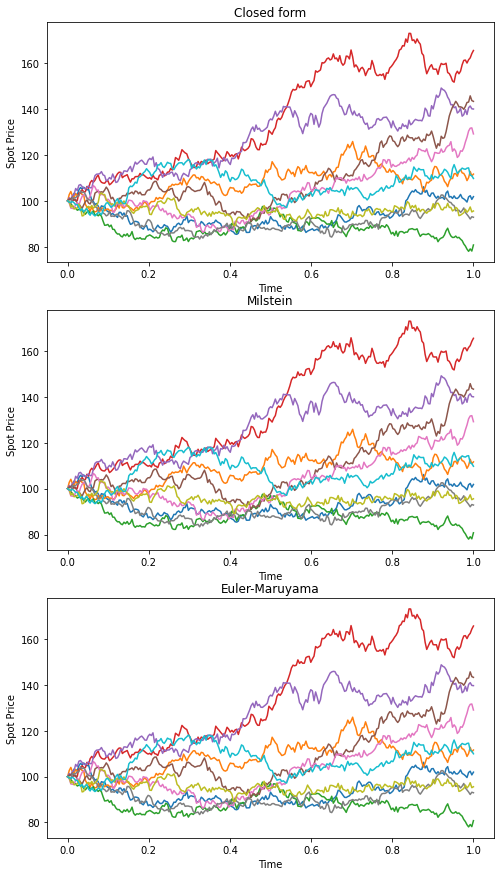

In [185]:
figure, axes = plt.subplots(3, 1, figsize=(8,15))
simulations = [GBM(T, day_count, r, sigma, S_0, 10, random_state=42).T,
               GBM_M(T, day_count, r, sigma, S_0, 10, random_state=42).T,
               GBM_EM(T, day_count, r, sigma, S_0, 10, random_state=42).T]
schemes = ['Closed form', 'Milstein', 'Euler-Maruyama']
for i, s in enumerate(simulations):
    axes[i].plot(np.linspace(0, T, day_count + 1), s)
    axes[i].set_title(schemes[i])
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Spot Price')
plt.show()

The simulations obtained by the three different methods with the given set of parameters appear identical to the naked eye. However, upon closer inspection, we can illustrate the difference in accuracy between the numerical schemes.

In [5]:
simulations_cf = GBM(T, day_count, r, sigma, S_0, 100000, random_state=42).T
simulations_em = GBM_EM(T, day_count, r, sigma, S_0, 100000, random_state=42).T
simulations_m = GBM_M(T, day_count, r, sigma, S_0, 100000, random_state=42).T

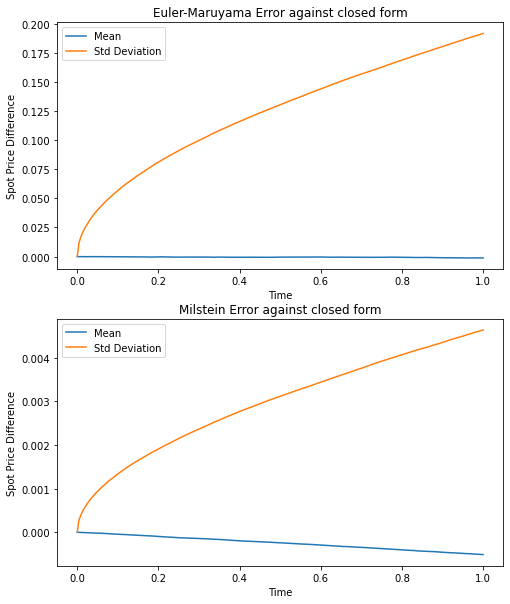

In [19]:
figure, axes = plt.subplots(2, 1, figsize=(8,10))
axes[0].plot(np.linspace(0, T, day_count + 1), (simulations_em - simulations_cf).mean(axis=1), label='Mean')
axes[0].plot(np.linspace(0, T, day_count + 1), (simulations_em - simulations_cf).std(axis=1), label='Std Deviation')
axes[0].set_title('Euler-Maruyama Error against closed form')
axes[0].legend()
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Spot Price Difference')
axes[1].plot(np.linspace(0, T, day_count + 1), (simulations_m - simulations_cf).mean(axis=1), label='Mean')
axes[1].plot(np.linspace(0, T, day_count + 1), (simulations_m - simulations_cf).std(axis=1), label='Std Deviation')
axes[1].set_title('Milstein Error against closed form')
axes[1].legend()
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Spot Price Difference')
plt.show()

Please note the different scaling on the y-axis of the two charts. As we would expect, the introduction of the Milstein correction term to the numerical scheme decreases the error ($O(\delta t)$ versus $O(\sqrt{\delta t})$). Also, quite expectedly, the increase in accuracy comes at the cost of a longer execution time:

In [7]:
%timeit GBM(T, day_count, r, sigma, S_0, 1, random_state=42)
%timeit GBM_M(T, day_count, r, sigma, S_0, 1, random_state=42)
%timeit GBM_EM(T, day_count, r, sigma, S_0, 1, random_state=42)

91.4 µs ± 837 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
3.05 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.71 ms ± 77.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Conclusion is somewhat standard for this kind of analysis. When applied to a real-life problem, the choice of simulation method will depend on the model, available resources, and the required accuracy. For the Asian option valuation under standard BSM (1973) assumptions, I am going to use closed-form simulations.

Fundamental asset pricing formula states that a value of derivative contract in classical assumptions is equal to its discounted expected payoff under risk-neutral measure $\mathbb Q$:

$$V(S, t) = e^{-r(T-t)}\mathbb E ^{\mathbb Q}[\text{Payoff}]$$

As we already implemented risk neutral simulations of underlying asset path, we can now approximate the expected value term in the above.

In [8]:
class OptionType(Enum):
    CALL = 0
    PUT = 1
    
class StrikeType(Enum):
    FIXED = 0
    FLOATING = 1

class SamplingType(Enum):
    DISCRETE = 0
    CONTINUOUS = 1

class AverageType(Enum):
    ARITHMETIC = 0
    GEOMETRIC = 1
    
class AsianOption:
    def __init__(self, option_type, strike_type, sampling_type, average_type, 
                 averaging_period_start, time_to_maturity,
                 sampling_freq = None, strike_price=None):
        self.option_type = option_type
        self.strike_type = strike_type
        self.sampling_type = sampling_type
        self.average_type = average_type
        self.averaging_period_start = averaging_period_start #in years
        self.time_to_maturity = time_to_maturity #in years
        self.sampling_freq = sampling_freq #in years
        self.strike_price = strike_price
        
    def get_average(self, hist_prices):
        n = len(hist_prices) - 1
        start = int(n * (averaging_period_start / self.time_to_maturity))
        averaging_period_prices = hist_prices[start:]
        if self.sampling_type == SamplingType.DISCRETE:
            if self.sampling_freq == None:
                raise ValueError("Sampling frequency must be specified for discrete averaging option")
            else:
                k = int( n * self.sampling_freq / self.time_to_maturity)
                if self.average_type == AverageType.ARITHMETIC:
                    average_price = np.mean(averaging_period_prices[::k])
                else:
                    average_price = gmean(averaging_period_prices[::k])
        else:
            if self.average_type == AverageType.ARITHMETIC:
                average_price = np.mean(averaging_period_prices)
            else:
                average_price = gmean(averaging_period_prices)
        return average_price
    
    def get_payoff(self, hist_prices):
        average_price = self.get_average(hist_prices)
        if self.strike_type == StrikeType.FIXED:
            if self.strike_price is None:
                raise ValueError("Strike price must be specified for fixed strike option")
            else:
                if self.option_type == OptionType.CALL:
                    payoff = max(average_price - self.strike_price, 0)
                else:
                    payoff = max(self.strike_price - average_price, 0)
        else:
            if self.option_type == OptionType.CALL:
                payoff = max(hist_prices[-1] - average_price, 0)
            else:
                payoff = max(average_price - hist_prices[-1], 0)
        return payoff
    
    def get_sim_mean(self, simulations):
        payoffs = []
        for i in range(simulations.shape[1]):
            payoffs.append(self.get_payoff(simulations[:,i]))
        return np.array(payoffs).mean()
    
    def get_mc_value(self, S, r, sigma, N, k=10000, random_state=None):
        T = self.time_to_maturity
        simulations_em = GBM(T, N, r, sigma, S, k, random_state=random_state).T
        return exp(-r * T) * self.get_sim_mean(simulations_em)
    
def bsm_value(S, K, T, r, q, sigma, Flag):
    #BSM-1973 formula extended for continous dividends or other yield
    from math import log, sqrt, exp
    from scipy import stats

    S = float(S)
    K = float(K)
    d1 = (log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S/K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    if Flag == 0:
        value = (S * exp(-q * T) * stats.norm.cdf(d1, 0.0, 1.0) -
                 K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    elif Flag == 1:
        value = (K * exp(-r * T) * stats.norm.cdf(-d2, 0.0, 1.0) -
                 S * exp(-q * T) * stats.norm.cdf(-d1, 0.0, 1.0))
    else:
        value = 'NaN'
    return value

def tw_asian_value(S, K, T, t1, r, sigma, Flag):
    #Lazy implementation covers only case when averaging period has not yet started
    T2 = T - t1
    tau = -t1
    if r == 0: 
        M1 = 1
        M2 = 2 * exp(T * sigma ** 2) / ((sigma ** 4) * ((T - t1) ** 2)) - \
        2 * exp(t1 * sigma ** 2) * (1 + (T - t1) * sigma ** 2) / ((sigma ** 4) * (T - t1) ** 2)
    else: 
        M1 = (exp(r * T) - exp(r * t1)) / (r * (T - t1))
        M2 = 2 * exp(T * (2 * r + sigma ** 2)) / \
        ((r + sigma ** 2) * (2 * r + sigma ** 2) * (T - t1) ** 2) + \
        2 * exp(t1 * (2 * r + sigma ** 2)) * \
        ((1 / (2 * r + sigma ** 2)) - exp(r * (T - t1)) / (r + sigma ** 2)) / \
        (r * (T - t1) ** 2)
    q = r - log(M1) / T
    v = sqrt((log(M2) / T) - 2 * log(M1) / T)
    return bsm_value(S, K, T, r, q, v, Flag)

Above, I have coded the Asian option payoff calculation as an AsianOption class. The implementation is straightforward, but a bit tedious. Therefore, in addition to standard testing and debugging, we can check the results against some well-known closed-form solutions or approximations.

First, if we average only one point at the expiry, we should expect the Asian option to be equivalent to a vanilla.

In [9]:
K = 100
print("Black-Scholes value for vanilla case")
print("call: %.2f, put: %.2f" % (bsm_value(S_0, K, T, r, 0, sigma, 0),
      bsm_value(S_0, K, T, r, 0, sigma, 1)))

vanilla_call_mc = exp(-r * T) * ((simulations_cf[-1,:] - K) * (simulations_cf[-1,:] > K)).mean()
vanilla_put_mc = exp(-r * T) * ((K - simulations_cf[-1,:]) * (simulations_cf[-1,:] < K)).mean()
strike_type = StrikeType.FIXED
average_type = AverageType.GEOMETRIC
sampling_type = SamplingType.CONTINUOUS 
averaging_period_start = T

call = AsianOption(OptionType.CALL, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, strike_price=100)
put = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, strike_price=100)
print("Monte Carlo value for reduced case of Asian option")
print("call: %.2f, put: %.2f" % (exp(-r * T) * call.get_sim_mean(simulations_cf), 
      exp(-r * T) * put.get_sim_mean(simulations_cf)))
print("Manual Monte Carlo value for reduced case of Asian option")
print("call: %.2f, put: %.2f" % (vanilla_call_mc, vanilla_put_mc))

Black-Scholes value for vanilla case
call: 10.45, put: 5.57
Monte Carlo value for reduced case of Asian option
call: 10.40, put: 5.55
Manual Monte Carlo value for reduced case of Asian option
call: 10.40, put: 5.55


Now we can use a well-known closed form solution for a geometric average Asian option:

In [10]:
print("Closed form solution for continuous geometric averaging case")
print("call: %.2f, put: %.2f" %
      (bsm_value(S_0, K, T, r, r - 0.5 * (r - (sigma ** 2) / 6), sigma / sqrt(3), 0),
      bsm_value(S_0, K, T, r, r - 0.5 * (r - (sigma ** 2) / 6), sigma / sqrt(3), 1)))

strike_type = StrikeType.FIXED
average_type = AverageType.GEOMETRIC
sampling_type = SamplingType.CONTINUOUS 
averaging_period_start = 0

call = AsianOption(OptionType.CALL, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, strike_price=100)
put = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, strike_price=100)
print("Monte Carlo value for 'continuous' geometric averaging case")
print("call: %.2f, put: %.2f" %
      (exp(-r * T) * call.get_sim_mean(simulations_cf),
       exp(-r * T) * put.get_sim_mean(simulations_cf)))

Closed form solution for continuous geometric averaging case
call: 5.55, put: 3.46
Monte Carlo value for 'continuous' geometric averaging case
call: 5.52, put: 3.48


I put quotes around 'continuous' for the Monte Carlo calculation because daily price averaging is used. While some scholars may disagree, I believe that daily data is commonly used by practitioners when referring to an option as 'continuous'.

Arithmetic average case does not have a closed form solution but we can utilize Turnbull-Wakeman (1991) approximation.

In [11]:
print("Turnbull-Wakeman approximation for arithmetic averaging asian option")
print("call: %.2f, put: %.2f" %
    (tw_asian_value(S_0, K, T, 0, r, sigma, 0),
     tw_asian_value(S_0, K, T, 0, r, sigma, 1)))
strike_type = StrikeType.FIXED
average_type = AverageType.ARITHMETIC
sampling_type = SamplingType.CONTINUOUS 
averaging_period_start = 0

call = AsianOption(OptionType.CALL, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, strike_price=100)
put = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, strike_price=100)
print("Monte Carlo value for 'continuous' arithmetic averaging case")
print("call: %.2f, put: %.2f" %
      (exp(-r * T) * call.get_sim_mean(simulations_cf),
       exp(-r * T) * put.get_sim_mean(simulations_cf)))

Turnbull-Wakeman approximation for arithmetic averaging asian option
call: 5.78, put: 3.36
Monte Carlo value for 'continuous' arithmetic averaging case
call: 5.74, put: 3.36


To test the implementation of floating strike type we can utilise fixed and floating stirkes symmetry for geomertric continuous averaging case:

In [12]:
option_type = OptionType.CALL
strike_type = StrikeType.FIXED
average_type = AverageType.GEOMETRIC
sampling_type = SamplingType.CONTINUOUS 
averaging_period_start = 0

option1 = AsianOption(option_type, strike_type, sampling_type, average_type, 
                 averaging_period_start, T,
                    strike_price=100)

option_type = OptionType.PUT
strike_type = StrikeType.FLOATING

option2 = AsianOption(option_type, strike_type, sampling_type, average_type, 
                 averaging_period_start, T,
                    strike_price=1)

print("fixed strike call: %.2f, floating strike put: %.2f" %
      (option1.get_mc_value(100, 0, 0.2, 252, 100000, 42),
       option2.get_mc_value(100, 0, 0.2, 252, 100000, 42)))

fixed strike call: 4.40, floating strike put: 4.40


Now that we have a bit more confidence in the implementation, we can compare the values of different types of Asian options together with vanilla European options.

In [13]:
option_types = [OptionType.CALL, OptionType.PUT]
strike_types = [StrikeType.FIXED, StrikeType.FLOATING]
average_types = [AverageType.ARITHMETIC, AverageType.GEOMETRIC]
sampling_types = [SamplingType.CONTINUOUS, SamplingType.DISCRETE]
all_types = [(t1, t2, t3, t4) for t1 in option_types for t2 in strike_types for t3 in average_types
             for t4 in sampling_types]
averaging_period_start = 0
sampling_freq = 0.25
output_table = pd.DataFrame(columns=['Option Type', 'Strike Type', 'Average Type',
                                    'Sampling Type', 'Monte Carlo Price'])
new_row = {'Option Type' : 'CALL',
           'Strike Type' : 'FIXED',
           'Average Type' : 'VANILLA',
           'Sampling Type' : 'VANILLA',
           'Monte Carlo Price' : vanilla_call_mc}
output_table = output_table.append(new_row, ignore_index=True)
new_row = {'Option Type' : 'PUT',
           'Strike Type' : 'FIXED',
           'Average Type' : 'VANILLA',
           'Sampling Type' : 'VANILLA',
           'Monte Carlo Price' : vanilla_put_mc}
output_table = output_table.append(new_row, ignore_index=True)
for t in all_types:
    (option_type, strike_type, average_type, sampling_type) = t
    option = AsianOption(option_type, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, sampling_freq, strike_price=100)
    value = exp(-r * T) * option.get_sim_mean(simulations_cf)
    new_row = {'Option Type' : str(option_type).split('.')[1],
              'Strike Type' : str(strike_type).split('.')[1],
              'Average Type' : str(average_type).split('.')[1],
              'Sampling Type' : str(sampling_type).split('.')[1],
              'Monte Carlo Price' : value}
    output_table = output_table.append(new_row, ignore_index=True)
output_table.style.format('{:.2f}', subset=['Monte Carlo Price']).hide_index()

Option Type,Strike Type,Average Type,Sampling Type,Monte Carlo Price
CALL,FIXED,VANILLA,VANILLA,10.40
PUT,FIXED,VANILLA,VANILLA,5.55
CALL,FIXED,ARITHMETIC,CONTINUOUS,5.74
CALL,FIXED,ARITHMETIC,DISCRETE,5.53
CALL,FIXED,GEOMETRIC,CONTINUOUS,5.52
CALL,FIXED,GEOMETRIC,DISCRETE,5.27
CALL,FLOATING,ARITHMETIC,CONTINUOUS,5.84
CALL,FLOATING,ARITHMETIC,DISCRETE,5.60
CALL,FLOATING,GEOMETRIC,CONTINUOUS,6.05
CALL,FLOATING,GEOMETRIC,DISCRETE,5.86


As a person who has never priced or traded Asian options before, I have only heard the opinion that Asian options are simply cheaper variations of vanilla options (although they also offer higher protection from spot market manipulation). There is some obvious logic behind this, since the average price is less volatile than the spot price. The results above also support this opinion. However, we should probably consider a wider range of scenarios to better understand the nuances.

For brevity purposes, in the analysis below, I decided to pick a single type of Asian option, and the same analysis for the rest of the option types is omitted from the final version of the assignment (in my opinion, without any loss of significance). As for a benchmark for comparison, I chose vanilla options, so the fixed type of strike is more comparable. We may say that the continuous sampling type of option is, in a sense, more "Asian" than discrete as it relies more on averaging. Also, I picked arithmetic averaging because for geometric averaging, we can use the closed-form solution, and doing Monte Carlo seems a bit unnecessary.

In [14]:
S_space = np.linspace(51, 150, 100)
values_S_calls = []
values_S_puts = []
values_S_vanilla_calls = []
values_S_vanilla_puts = []

K_space = np.linspace(51, 150, 100)
values_K_calls = []
values_K_puts = []
values_K_vanilla_calls = []
values_K_vanilla_puts = []

r_space = np.linspace(0.005, 0.1, 20)
values_r_calls = []
values_r_puts = []
values_r_vanilla_calls = []
values_r_vanilla_puts = []

days_space = np.linspace(21, 501, 97)
values_days_calls = []
values_days_puts = []
values_days_vanilla_calls = []
values_days_vanilla_puts = []

sigma_space = np.linspace(0.11, 0.3, 20)
values_sigma_calls = []
values_sigma_puts = []
values_sigma_vanilla_calls = []
values_sigma_vanilla_puts = []


strike_type = StrikeType.FIXED
average_type = AverageType.ARITHMETIC
sampling_type = SamplingType.CONTINUOUS 
averaging_period_start = 0

call_option = AsianOption(OptionType.CALL, strike_type, sampling_type, average_type,
                     averaging_period_start, T, strike_price=K)
put_option = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type,
                     averaging_period_start, T, strike_price=K)
for S in S_space:
    simulations = GBM(T, day_count, r, sigma, S, 10000, random_state=42).T
    values_S_calls.append(exp(-r * T) * call_option.get_sim_mean(simulations))
    values_S_puts.append(exp(-r * T) * put_option.get_sim_mean(simulations))
    values_S_vanilla_calls.append(bsm_value(S, K, T, r, 0, sigma, 0))
    values_S_vanilla_puts.append(bsm_value(S, K, T, r, 0, sigma, 1))
for rate in r_space: 
    simulations = GBM(T, day_count, rate, sigma, S_0, 10000, random_state=42).T
    values_r_calls.append(exp(-rate * T) * call_option.get_sim_mean(simulations))
    values_r_puts.append(exp(-rate * T) * put_option.get_sim_mean(simulations))
    values_r_vanilla_calls.append(bsm_value(S_0, K, T, rate, 0, sigma, 0))
    values_r_vanilla_puts.append(bsm_value(S_0, K, T, rate, 0, sigma, 1))
for vol in sigma_space:
    simulations = GBM(T, day_count, r, vol, S_0, 10000, random_state=42).T
    values_sigma_calls.append(exp(-r * T) * call_option.get_sim_mean(simulations))
    values_sigma_puts.append(exp(-r * T) * put_option.get_sim_mean(simulations))
    values_sigma_vanilla_calls.append(bsm_value(S_0, K, T, r, 0, vol, 0))
    values_sigma_vanilla_puts.append(bsm_value(S_0, K, T, r, 0, vol, 1))
simulations = GBM(T, day_count, r, sigma, S_0, 10000, random_state=42).T
for strike in K_space:
    call_option = AsianOption(OptionType.CALL, strike_type, sampling_type, average_type,
                     averaging_period_start, T, strike_price=strike)
    put_option = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type,
                     averaging_period_start, T, strike_price=strike)
    values_K_calls.append(exp(-r * T) * call_option.get_sim_mean(simulations))
    values_K_puts.append(exp(-r * T) * put_option.get_sim_mean(simulations))
    values_K_vanilla_calls.append(bsm_value(S_0, strike, T, r, 0, sigma, 0))
    values_K_vanilla_puts.append(bsm_value(S_0, strike, T, r, 0, sigma, 1))
simulations = GBM(2, 2 * day_count, r, sigma, S_0, 10000, random_state=42).T
for days in days_space:
    call_option = AsianOption(OptionType.CALL, strike_type, sampling_type, average_type,
                     averaging_period_start, days / day_count, strike_price=K)
    put_option = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type,
                     averaging_period_start, days / day_count, strike_price=K)
    values_days_calls.append(exp(-r * (days / day_count)) * call_option.get_sim_mean(simulations[:int(days)]))
    values_days_puts.append(exp(-r * (days / day_count)) * put_option.get_sim_mean(simulations[:int(days)]))
    values_days_vanilla_calls.append(bsm_value(S_0, K, (days / day_count), r, 0, sigma, 0))
    values_days_vanilla_puts.append(bsm_value(S_0, K, (days / day_count), r, 0, sigma, 1))

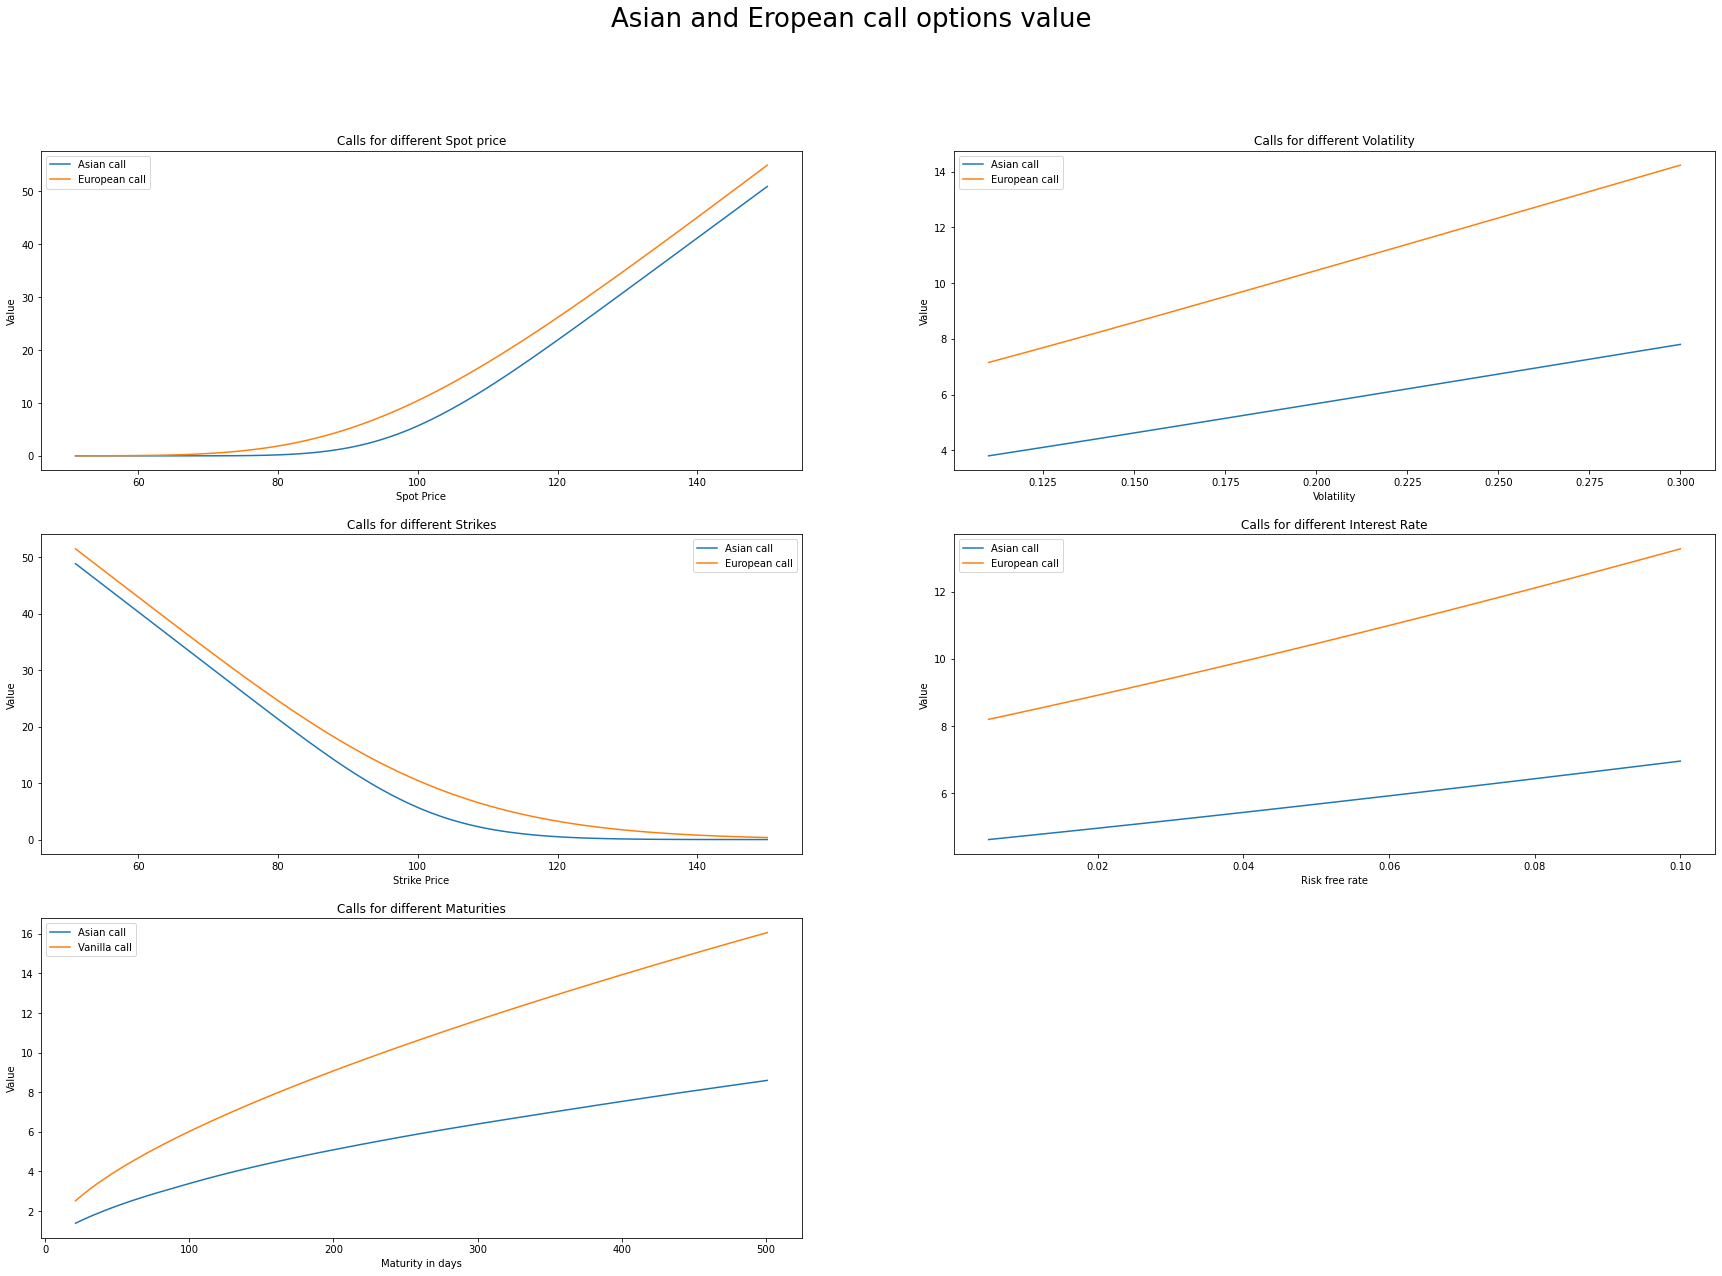

In [24]:
figure, axes = plt.subplots(3, 2, figsize=(30, 20))
figure.suptitle('Asian and Eropean call options value', fontsize=26)
axes[0,0].plot(S_space, values_S_calls, label='Asian call')
axes[0,0].plot(S_space, values_S_vanilla_calls, label='European call')
axes[0,0].set_title('Calls for different Spot price')
axes[0,0].legend()
axes[0,0].set_xlabel('Spot Price')
axes[0,0].set_ylabel('Value')
axes[0,1].plot(sigma_space, values_sigma_calls, label='Asian call')
axes[0,1].plot(sigma_space, values_sigma_vanilla_calls, label='European call')
axes[0,1].set_title('Calls for different Volatility')
axes[0,1].legend()
axes[0,1].set_xlabel('Volatility')
axes[0,1].set_ylabel('Value')
axes[1,1].plot(r_space, values_r_calls, label='Asian call')
axes[1,1].plot(r_space, values_r_vanilla_calls, label='European call')
axes[1,1].set_title('Calls for different Interest Rate')
axes[1,1].legend()
axes[1,1].set_xlabel('Risk free rate')
axes[1,1].set_ylabel('Value')
axes[1,0].plot(K_space, values_K_calls, label='Asian call')
axes[1,0].plot(K_space, values_K_vanilla_calls, label='European call')
axes[1,0].set_title('Calls for different Strikes')
axes[1,0].legend()
axes[1,0].set_xlabel('Strike Price')
axes[1,0].set_ylabel('Value')
axes[2,0].plot(days_space, values_days_calls, label='Asian call')
axes[2,0].plot(days_space, values_days_vanilla_calls, label='Vanilla call')
axes[2,0].set_title('Calls for different Maturities')
axes[2,0].legend()
axes[2,0].set_xlabel('Maturity in days')
axes[2,0].set_ylabel('Value')
axes[2,1].axis('off')
plt.show()

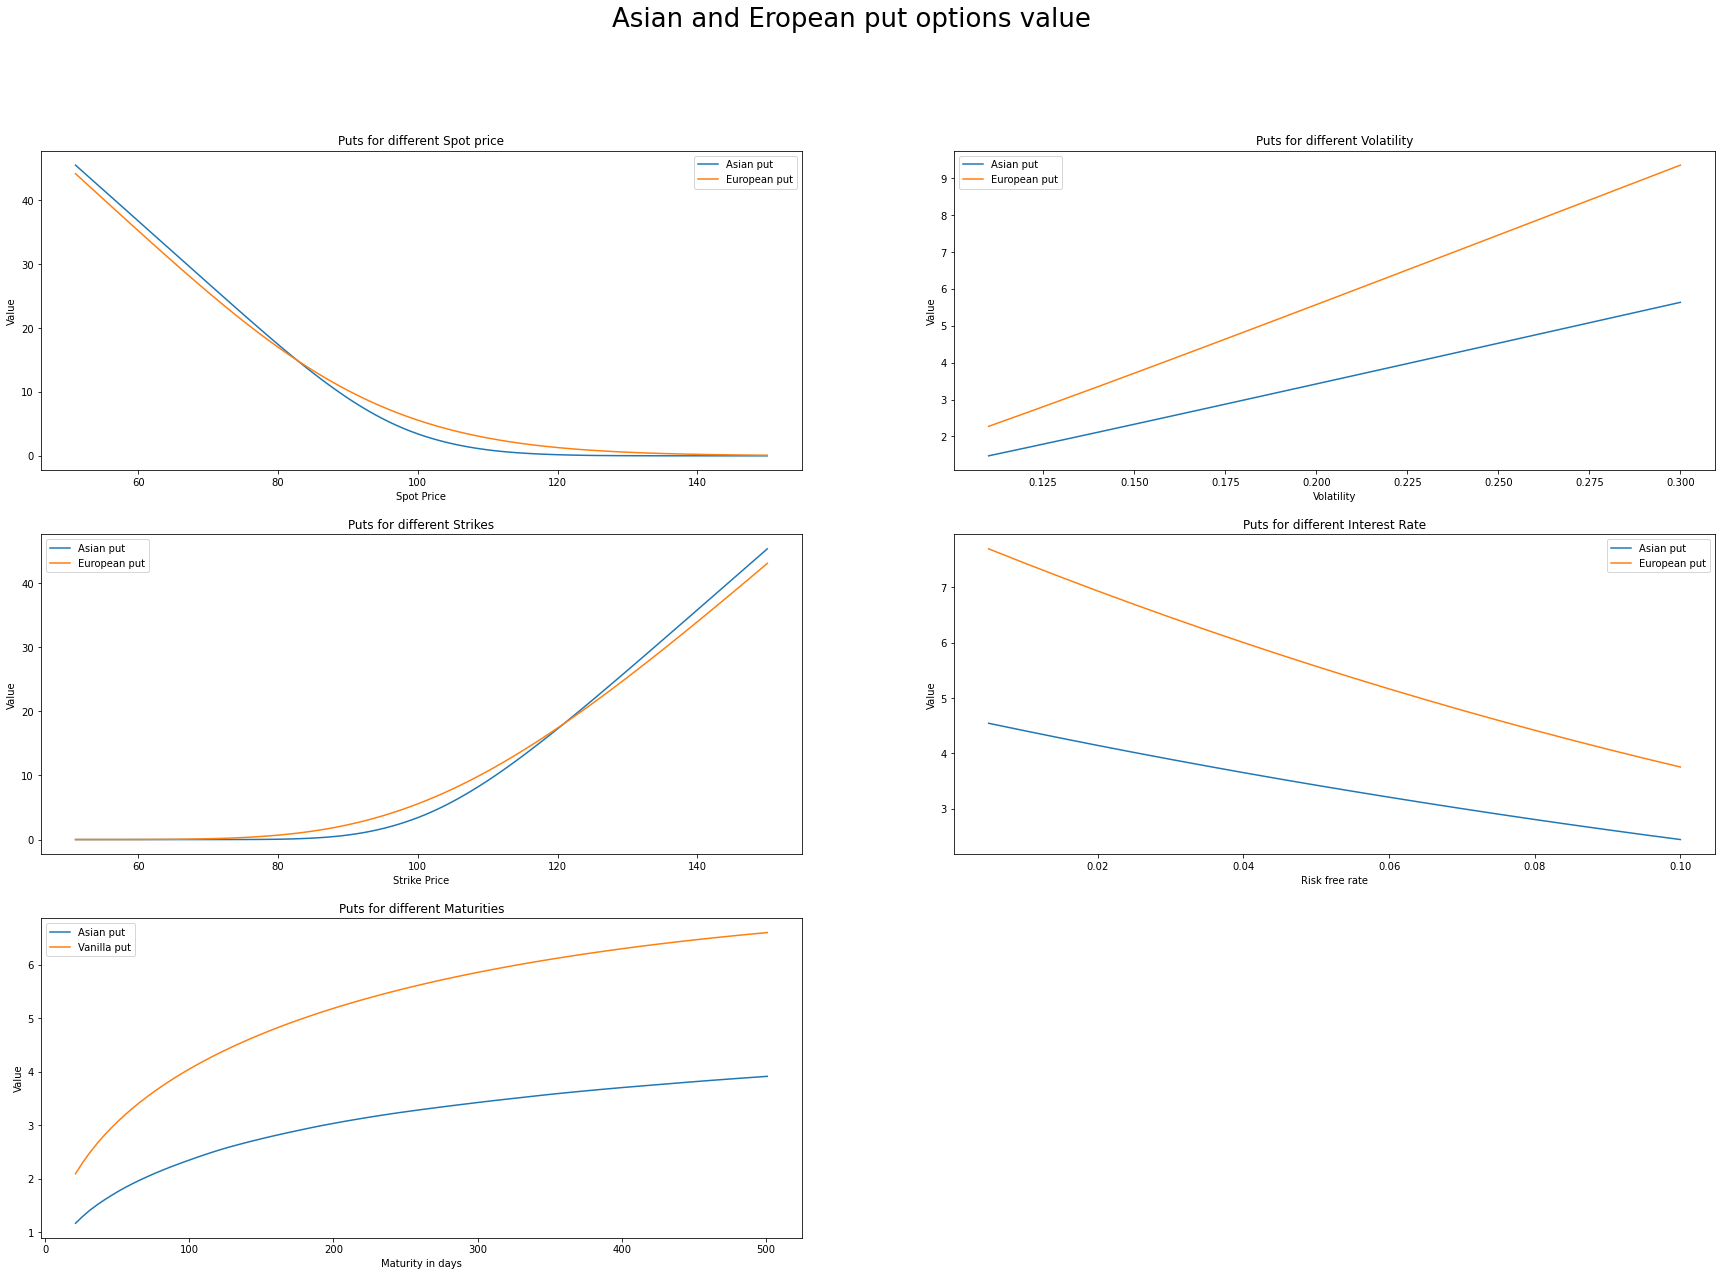

In [25]:
figure, axes = plt.subplots(3, 2, figsize=(30, 20))
figure.suptitle('Asian and European put options value', fontsize=26)
axes[0,0].plot(S_space, values_S_puts, label='Asian put')
axes[0,0].plot(S_space, values_S_vanilla_puts, label='European put')
axes[0,0].set_title('Puts for different Spot price')
axes[0,0].legend()
axes[0,0].set_xlabel('Spot Price')
axes[0,0].set_ylabel('Value')
axes[0,1].plot(sigma_space, values_sigma_puts, label='Asian put')
axes[0,1].plot(sigma_space, values_sigma_vanilla_puts, label='European put')
axes[0,1].set_title('Puts for different Volatility')
axes[0,1].legend()
axes[0,1].set_xlabel('Volatility')
axes[0,1].set_ylabel('Value')
axes[1,1].plot(r_space, values_r_puts, label='Asian put')
axes[1,1].plot(r_space, values_r_vanilla_puts, label='European put')
axes[1,1].set_title('Puts for different Interest Rate')
axes[1,1].legend()
axes[1,1].set_xlabel('Risk free rate')
axes[1,1].set_ylabel('Value')
axes[1,0].plot(K_space, values_K_puts, label='Asian put')
axes[1,0].plot(K_space, values_K_vanilla_puts, label='European put')
axes[1,0].set_title('Puts for different Strikes')
axes[1,0].legend()
axes[1,0].set_xlabel('Strike Price')
axes[1,0].set_ylabel('Value')
axes[2,0].plot(days_space, values_days_puts, label='Asian put')
axes[2,0].plot(days_space, values_days_vanilla_puts, label='Vanilla put')
axes[2,0].set_title('Puts for different Maturities')
axes[2,0].legend()
axes[2,0].set_xlabel('Maturity in days')
axes[2,0].set_ylabel('Value')
axes[2,1].axis('off')
plt.show()

From the charts, we can see that the properties of Asian options are similar to those of vanilla options, at least qualitatively. In most cases, Asian options are cheaper variations of vanilla options. However, this is not true for deep in-the-money puts, where the vanilla option value lies below the Asian option value. We know that in-the-money options can be rather sensitive to the cost of carry and potentially less sensitive to volatility, as their intrinsic value becomes higher and their time value becomes lower (or we can we can explain it by the effects of drift and diffusion to sound more like quants). In the case of in-the-money puts, Asian options benefit from the fact that as the spot price drifts higher, the average price is expected to be lower than the price at maturity. If this effect is really the main driver of the charts above, then it should become stronger as we consider higher interest rates and lower volatility. By a stronger effect, I mean that the difference between their value should increase in favor of the Asian option and their intersection should be closer to at-the-money. To illustrate we can use the example of $\sigma_{-}=0.15$ and $r_{+}=0.1$ to calculate new option value $V^*$ and see if the described effect really appears: 

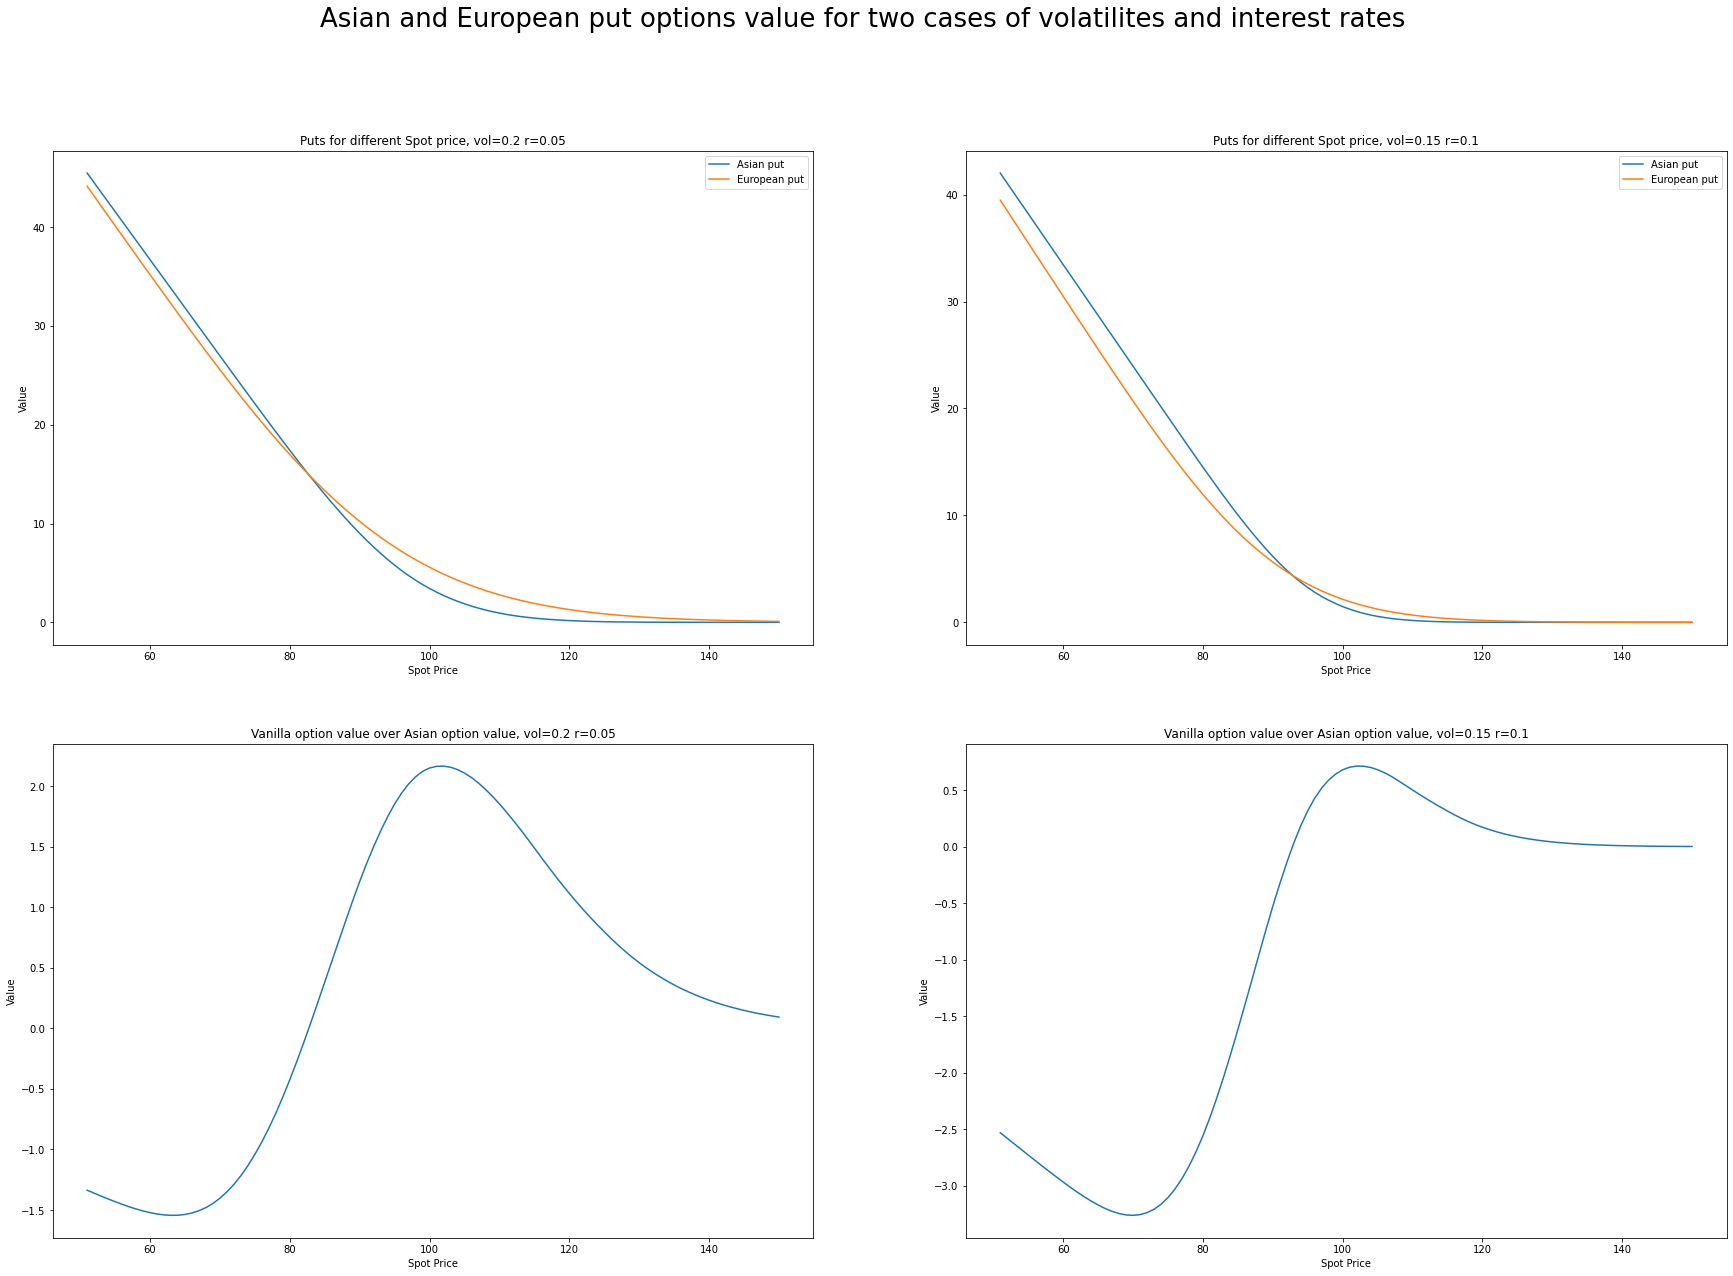

In [35]:
r_plus = 0.1
sigma_minus = 0.15

values_S_puts_star = []
values_S_vanilla_puts_star = []

put_option = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type,
                     averaging_period_start, T, strike_price=K)
for S in S_space:
    simulations = GBM(T, day_count, r_plus, sigma_minus, S, 10000, random_state=42).T
    values_S_puts_star.append(exp(-r_plus * T) * put_option.get_sim_mean(simulations))
    values_S_vanilla_puts_star.append(bsm_value(S, K, T, r_plus, 0, sigma_minus, 1))

figure, axes = plt.subplots(2, 2, figsize=(30, 20))
figure.suptitle('Asian and European put options value for two cases of volatilites and interest rates', fontsize=26)
axes[0,0].plot(S_space, values_S_puts, label='Asian put')
axes[0,0].plot(S_space, values_S_vanilla_puts, label='European put')
axes[0,0].set_title('Puts for different Spot price, vol=0.2 r=0.05')
axes[0,0].legend()
axes[0,0].set_xlabel('Spot Price')
axes[0,0].set_ylabel('Value')
axes[1,0].plot(S_space, np.array(values_S_vanilla_puts) - np.array(values_S_puts),)
axes[1,0].set_xlabel('Spot Price')
axes[1,0].set_ylabel('Value')
axes[1,0].set_title('Vanilla option value over Asian option value, vol=0.2 r=0.05')
axes[0,1].plot(S_space, values_S_puts_star, label='Asian put')
axes[0,1].plot(S_space, values_S_vanilla_puts_star, label='European put')
axes[0,1].set_title('Puts for different Spot price, vol=0.15 r=0.1')
axes[0,1].legend()
axes[0,1].set_xlabel('Spot Price')
axes[0,1].set_ylabel('Value')
axes[1,1].plot(S_space, np.array(values_S_vanilla_puts_star) - np.array(values_S_puts_star))
axes[1,1].set_xlabel('Spot Price')
axes[1,1].set_ylabel('Value')
axes[1,1].set_title('Vanilla option value over Asian option value, vol=0.15 r=0.1')
plt.show()

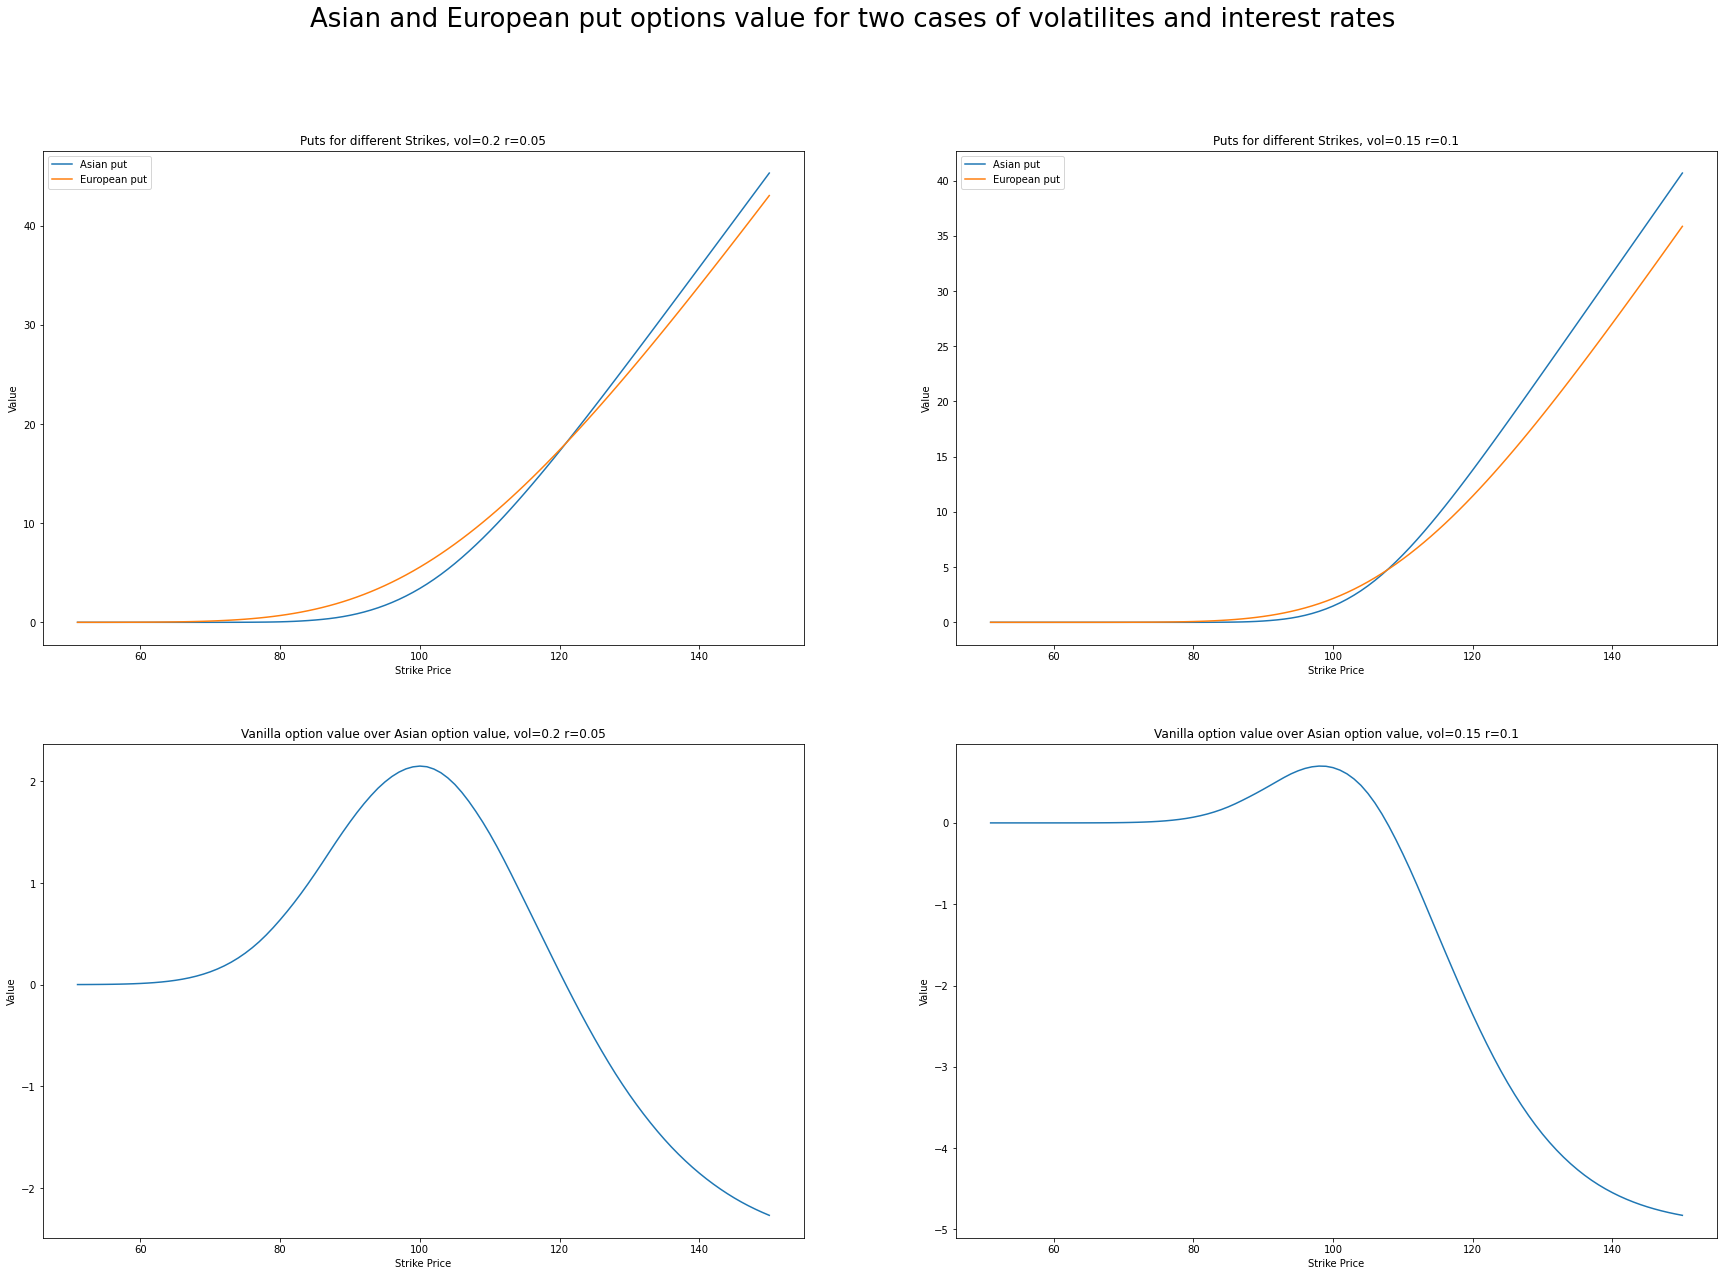

In [32]:
values_K_puts_star = []
values_K_vanilla_puts_star = []

simulations = GBM(T, day_count, r_plus, sigma_minus, S_0, 10000, random_state=42).T
for strike in K_space:
    put_option = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type,
                     averaging_period_start, T, strike_price=strike)
    values_K_puts_star.append(exp(-r_plus * T) * put_option.get_sim_mean(simulations))
    values_K_vanilla_puts_star.append(bsm_value(S_0, strike, T, r_plus, 0, sigma_minus, 1))

figure, axes = plt.subplots(2, 2, figsize=(30, 20))
figure.suptitle('Asian and European put options value for two cases of volatilites and interest rates', fontsize=26)
axes[0,0].plot(K_space, values_K_puts, label='Asian put')
axes[0,0].plot(K_space, values_K_vanilla_puts, label='European put')
axes[0,0].set_title('Puts for different Strikes, vol=0.2 r=0.05')
axes[0,0].legend()
axes[0,0].set_xlabel('Strike Price')
axes[0,0].set_ylabel('Value')
axes[1,0].plot(K_space, np.array(values_K_vanilla_puts) - np.array(values_K_puts))
axes[1,0].set_xlabel('Strike Price')
axes[1,0].set_ylabel('Value')
axes[1,0].set_title('Vanilla option value over Asian option value, vol=0.2 r=0.05')
axes[0,1].plot(K_space, values_K_puts_star, label='Asian put')
axes[0,1].plot(K_space, values_K_vanilla_puts_star, label='European put')
axes[0,1].set_title('Puts for different Strikes, vol=0.15 r=0.1')
axes[0,1].legend()
axes[0,1].set_xlabel('Strike Price')
axes[0,1].set_ylabel('Value')
axes[1,1].plot(S_space, np.array(values_K_vanilla_puts_star) - np.array(values_K_puts_star))
axes[1,1].set_xlabel('Strike Price')
axes[1,1].set_ylabel('Value')
axes[1,1].set_title('Vanilla option value over Asian option value, vol=0.15 r=0.1')
plt.show()

The charts above support the earlier explanation. Of course, instead of relying on computations, we could consider an example of a process with a constant drift but zero diffusion. In this case, Asian puts are either more expensive than European puts, or both their values are zero. For some subset, the European value is equal to 0 while the Asian value is positive.

To conclude, the argument that Asian options are used to cheapen European options is often correct in practice, but it still needs to be handled with caution. More generally speaking, the "moneyness" of Asian and European options is different. One extremely obvious consequence is that when using Asian options instead of European options in practice, one needs to consider strike adjustment (and possibly maturity adjustment as well). Another less obvious result is that, even though Monte Carlo simulations method under the assumptions of BSM (1973) is convenient and simple, and in some cases, closed-form or approximate solutions exist, when valuing Asian options in real life, one must choose the correct volatility and interest rate (which should be easier). In the presence of a non-flat volatility surface for vanillas, given the described effect, it may be wrong to simply use the volatility of the same strike and maturity for Asian option. It is not immediately clear which point on the surface should be the input for the Asian option valuation. Probably a single volatility point may not be enough in practice. If my career relied on the adequate pricing and valuation of Asian options, I would start looking at more advanced models that are calibrated to the entire volatility surface, rather than to one constant value.

# Task 2

For the problem with general form of:

$$\dfrac{d^2y}{dx^2} + P(x)\dfrac{dy}{dx} + Q(x)y=f(x)$$

$$s.t \quad y(a)=\alpha, \quad y(b)=\beta$$

we consider the regular interval mesh $\{x_i\}_{i=0}^{n},$ where $x_0=a$ and $x_n=b$. We denote 

$$\delta x = \dfrac{b-a}{n}, \quad y_i=y(x_i), \quad P_i=P(x_i), \quad Q_i=Q(x_i), \quad f_i=f(x_i)$$

Now we approximate first and second order derivatives of $y$ with central differences:

$$\dfrac{dy}{dx}\approx \dfrac{y_{i+1}-y_{y-1}}{2\delta x}$$

$$\dfrac{d^2y}{dx^2}\approx\dfrac{y_{i+1}+y_{y-1}-2y_i}{\delta x^2}$$

Subsituting everything into the original model for for points on the mesh where $i=1,..., n-1$ and multiplying both sides by $\delta x^2$, we get

$$y_{y+1} + y_{i-1} - 2y_i + P_i \delta x \dfrac{y_{i+1} - y_{i-1}}{2} + Q_iy_i\delta x^2 = \delta x^2 f_i$$

After rearranging the terms, we get

$$(1 + \dfrac{\delta x}{2}P_i)y_{y+1} + (-2+\delta x^2 Q_i)y_i + (1 - \dfrac{\delta x}{2}P_i)y_{y-1} = \delta x^2 f_i$$

Thus we have obtained $n-1$ equations for $n+1$ variables. Two more are simply the boundary conditions

$$y_0 = \alpha, \quad y_n= \beta$$

Now we have a system of linear equations in form of $A\textbf{y}=\textbf{v}$, where

$$A = 
\begin{bmatrix}
1 & 0 & 0 & 0 & \dots & 0 & 0 & 0 \\
(1 - \dfrac{\delta x}{2}P_1) & (-2+\delta x^2 Q_1) & (1 + \dfrac{\delta x}{2}P_1) & 0 & \dots & 0 & 0 & 0 \\
 \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \dots & (1 - \dfrac{\delta x}{2}P_{n-1}) & (-2+\delta x^2 Q_{n-1}) & (1 + \dfrac{\delta x}{2}P_{n-1})\\
0 & 0 & 0 & 0 & \dots & 0 & 0 & 1 \\
\end{bmatrix}
$$

$$\textbf{y}=
\begin{pmatrix}
y_0 \\ \vdots \\ y_n
\end{pmatrix}
$$

$$\textbf{v}=
\begin{pmatrix}
\alpha \\ (\delta x^2)f_1 \\ \vdots \\ (\delta x^2)f_{n-1} \\ \beta
\end{pmatrix}
$$

Provided that $A$ is full rank, solving it is equivalent to inversing the matrix with dimensions $(n+1) \times (n+1)$, i.e., $\textbf{y}=A^{-1}\textbf{v}$. We should note here that $A$ is tridiagonal matrix; hence, solving the system of linear equations should not be as computationally heavy as it could be for a more general case.

Now we are ready to apply the above to solving differential equation

$$\dfrac{d^2y}{dx^2} + 3\dfrac{dy}{dx} + 2y=4x^2, \quad y(1)=1, \quad y(2)=6$$

In this case $P(x)$ and $Q(x)$ are constants. For different numbers $n$ we define a mesh on $[0,1]$ and $\delta x$, then solve corresponding system of linear equations. Luckily, we can solve this differential equation analytically and then compare the results. Analytical solution for differential equiation:

$$g(x)=C_1 exp(-2x) + C_2 exp(-x) + 2x^2 -6x + 7,$$

where $C_1=3e^4 - \dfrac{3e^4+2e^2}{1-e^{-1}}$ and $C_2=\dfrac{3e^2+2}{1-e^{-1}}$

In [54]:
def numerical_solution(n=10):
    x_0, x_n = 1, 2
    y_0, y_n = 1, 6
    P = np.ones(n+1) * 3
    Q = np.ones(n+1) * 2
    ###
    x = np.linspace(x_0, x_n, n+1)
    y = np.zeros(n+1)
    y[0] = y_0
    y[n] = y_n
    dx = (x_n - x_0) / n
    f = 4 * x ** 2

    A = np.zeros((n + 1, n + 1))
    v = np.zeros(n + 1)
    A[0, 0] = 1
    A[n, n] = 1
    v[0], v[n] = 1, 6
    for i in range(1, n, 1):
        A[i, i -1 ] = 1 - P[i] * dx / 2
        A[i, i] = Q[i] * (dx ** 2) - 2
        A[i, i + 1] = 1 + P[i] * dx / 2
        v[i] = (dx ** 2) * f[i]
    return x, np.linalg.inv(A) @ v

def analytical_solution(x):
    C_1 = 3 * exp(4) - (3 * exp(4) + 2 * exp(2)) / (1 - exp(-1))
    C_2 = (3 * exp(2) + 2) / (1 - exp(-1))
    return C_1 * np.exp(-2 * x) + C_2 * np.exp(-x) + 2 * x ** 2 - 6 * x + 7

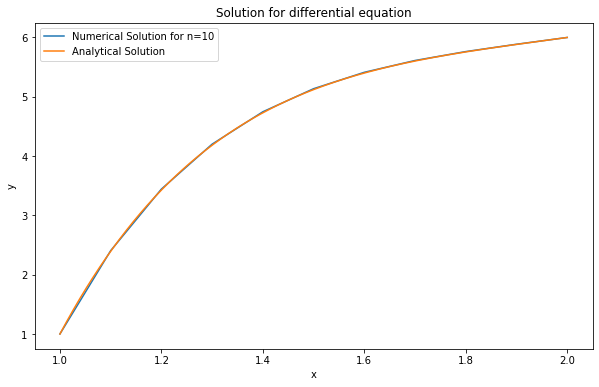

In [68]:
x, y = numerical_solution()
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Numerical Solution for n=10')
plt.plot(np.linspace(1, 2, 1000), analytical_solution(np.linspace(1, 2, 1000)), label='Analytical Solution')
plt.title('Solution for differential equation')
plt.legend(loc='upper left', frameon=True)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We can hardly distinguish the two lines in this chart. This signals that my code is probably correct (or at least the number of errors in it is even). To see how the numerical procedure performs, we need to take a closer look at the errors. Let's consider just a simple difference between the analytical and numerical solutions on the mesh $\{x_i\}_{i=0}^{n}$:

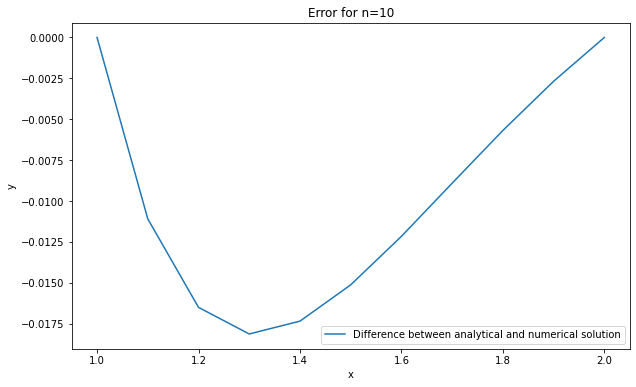

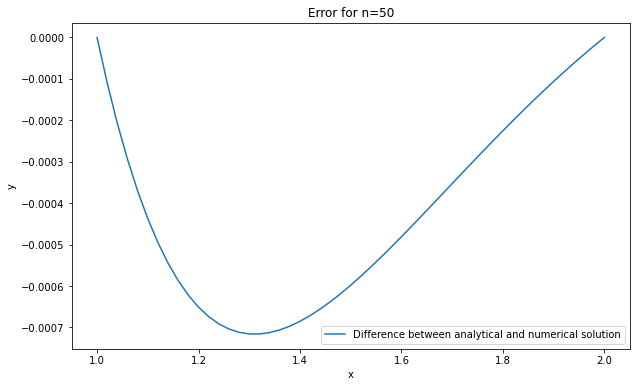

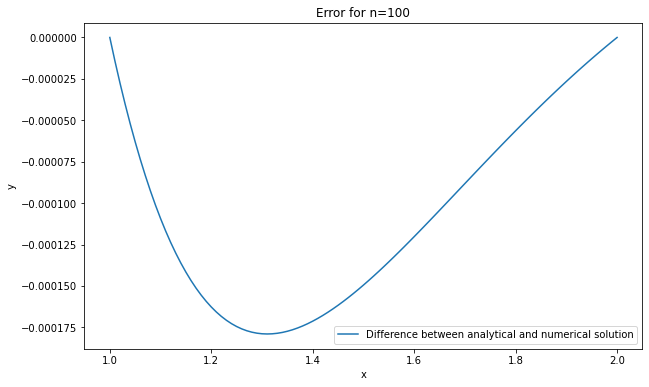

In [67]:
for n in [10, 50, 100]:
    x, y = numerical_solution(n)
    plt.figure(figsize=(10, 6))
    plt.plot(x, analytical_solution(x) -  y, label='Difference between analytical and numerical solutions')
    plt.legend(loc='lower right', frameon=True)
    plt.title('Error for n=' + str(n))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

We expected the error to be $O(\delta x^2)$ as a result of Taylor series expansion and the approximations that we used for $\dfrac{d^2y}{dx^2}$ and $\dfrac{dy}{dx}$. Here we nicely confirm it with the example.

I should note that in my numerical procedure I used standard numpy matrix inversion function which is generic and probably not very efficient for matrices with good properties like in our case. With this particular example for the $n=10, 50, 100$ calculation time is not an issue but we know that in general case complexity of direct invesrsion algorithm like Gaussian elimination is $O(n^3)$, so we should expect nothing good out of this procedure if $n$ increases:

In [69]:
#careful, takes some time
for n in [10, 100, 1000, 10000]:
    %timeit numerical_solution(n)

112 µs ± 5.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
636 µs ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
50.6 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
35.9 s ± 2.47 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


As the system of linear equations in our case is formed by a tridiagonal matrix, we can try better algorithms tailored specifically for such cases. Here is my attempt at implementing the Thomas algorithm, which exploits the structure of the matrix:

In [93]:
def thomas_algorithm(A, v):
    n = A.shape[0]
    a = np.diag(A, k=-1).copy()
    b = np.diag(A).copy()
    c = np.diag(A, k=1).copy()
    for i in range(1, n):
        m = a[i-1] / b[i-1]
        b[i] -= m * c[i-1]
        v[i] -= m * v[i-1]
    x = np.zeros(n)
    x[-1] = v[-1] / b[-1]
    for i in range(n-2, -1, -1):
        x[i] = (v[i] - c[i] * x[i+1]) / b[i]
    return x

def numerical_solution_tridiag(n=10):
    x_0, x_n = 1, 2
    y_0, y_n = 1, 6
    P = np.ones(n+1) * 3
    Q = np.ones(n+1) * 2
    ###
    x = np.linspace(x_0, x_n, n+1)
    y = np.zeros(n+1)
    y[0] = y_0
    y[n] = y_n
    dx = (x_n - x_0) / n
    f = 4 * x ** 2

    A = np.zeros((n + 1, n + 1))
    v = np.zeros(n + 1)
    A[0, 0] = 1
    A[n, n] = 1
    v[0], v[n] = 1, 6
    for i in range(1, n, 1):
        A[i, i -1 ] = 1 - P[i] * dx / 2
        A[i, i] = Q[i] * (dx ** 2) - 2
        A[i, i + 1] = 1 + P[i] * dx / 2
        v[i] = (dx ** 2) * f[i]
    return x, thomas_algorithm(A, v)

In [94]:
for n in [10, 100, 1000, 10000]:
    %timeit numerical_solution_tridiag(n)

143 µs ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
722 µs ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.99 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
93 ms ± 2.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The results are quite reassuring. We can see that when $n$ is low, my clumsy code with multiple reassignments and for-loops is no match for vectorized calculations by numpy. But with the increase of $n$, the solution with the tridiagonal algorithm quickly starts to outperform the more general method. Two conclusions can be made from this. First, the algorithm from the standard library is not optimized for a specific plausible case like the tridiagonal matrix. Second, good math beats bad code sometimes. If I were good at math, this would be great news for me. Manual implementation of some methods still sometimes pays off even though lots of packages are widely available.

## Task 3
### Monte Carlo Intergration
### i.

$$\int_{1}^{3} x^2 dx$$

Here we need to rescale and recenter the function to present the integral in the form of expectation of function of $U(0,1)$. It becomes:

$$2 \int_{0}^{1} (2y + 1)^2 dy$$

which we now can code and compare with the exact solution which is according to my math is $\dfrac{26}{3}$

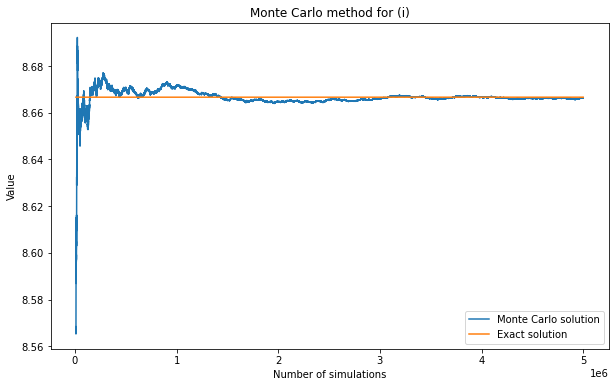

Numerical value of the integral (i) after 5000000 simulations is 8.6664


In [152]:
def func_i(y):
    return 2 * ((2 * y + 1) ** 2)

N = 5000000
np.random.seed(42)

vector_i = func_i(np.random.uniform(0, 1, N))

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, N + 1)[10000:],  (vector_i.cumsum() / np.arange(1, N + 1))[10000:],
         label="Monte Carlo solution")
plt.plot(np.arange(1, N + 1)[10000:], [26 / 3] * len(np.arange(1, N + 1)[10000:]), label='Exact solution')
plt.legend(loc='lower right', frameon=True)
plt.title('Monte Carlo method for (i)')
plt.xlabel('Number of simulations')
plt.ylabel('Value')
plt.show()
print("Numerical value of the integral (i) after %d simulations is %.4f" % (N, vector_i.mean()))

We should note that the original integral was already in the form of an expectation, but for the function $2x^2$ of $U(1,3)$, and we can try to evaluate it with less manipulation. As I have absolutely no idea how the random number generator is implemented in numpy (I am sure it just rescales and recenteres $U(0,1)$ but still), I am just going to test it to see if there is going to be any difference:

In [177]:
np.random.seed(42)
print(func_i(np.random.uniform(0, 1, N)).mean(),
    2 * (np.random.uniform(1, 3, N) ** 2).mean())
%timeit func_i(np.random.uniform(0, 1, N)).mean()
%timeit (2 * (np.random.uniform(1, 3, N) ** 2).mean())

8.666354110076993 8.666736158097097
69.5 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.2 ms ± 642 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### ii.

$$\int_{0}^{\infty} exp(-x^2) dx$$

Again, we need to change the variable to bring the upper bound of the integral to 1. After all manipulations, we get:

$$\int_{0}^{1}g(y)dy = \int_{0}^{1} \dfrac{exp(-(\dfrac{1}{y}-1)^2)}{y^2} dy $$

That looks again like something we can code and see if numerical answer is close to $\dfrac{\sqrt{\pi}}{2}$. In this case we should be aware of potential division by a number very close to zero so we need to avoid it. Instead of integration of $[0,1]$ here I do $[\varepsilon, 1]$. I picked $\varepsilon$ as a square root of smallest positive float64 number. I believe can also account for the truncated part for example by doing flat extrapolation and by adding $\varepsilon g(\varepsilon)$ to the simulated values. But according to python $\varepsilon g(\varepsilon)=0$ and accordig to me it is just extremely small, so I will not bother with it

In [184]:
def func_ii(y):
    return np.exp(-((1 / y) - 1) ** 2) / (y ** 2)

eps = sqrt(2.2250738585072014e-308)

print((eps * func_ii(eps) == 0))

True


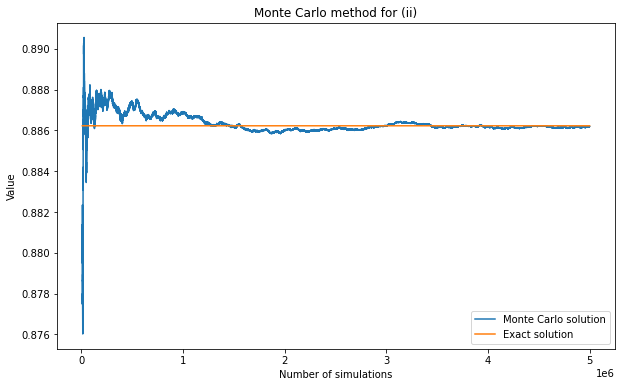

Numerical value of the integral (ii) after 5000000 simulations is 0.8862


In [194]:
N = 5000000
np.random.seed(42)

vector_ii = func_ii(np.random.uniform(eps, 1, N))
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, N + 1)[10000:],  (vector_ii.cumsum() / np.arange(1, N + 1))[10000:],
         label="Monte Carlo solution")
plt.plot(np.arange(1, N + 1)[10000:], [sqrt(pi) / 2] * len(np.arange(1, N + 1)[10000:]), label='Exact solution')
plt.legend(loc='lower right', frameon=True)
plt.title('Monte Carlo method for (ii)')
plt.xlabel('Number of simulations')
plt.ylabel('Value')
plt.show()
print("Numerical value of the integral (ii) after %d simulations is %.4f" % (N, vector_ii.mean()))

### iii.

$$\dfrac{1}{\sqrt{2\pi}}\int_{-\infty}^{+\infty} x^4 exp(-x^2/2) dx$$

Once again, we perform the necessary rearrangements and notice that the function is even, giving us:

$$\sqrt{\dfrac{2}{\pi}}\int_{0}^{1}\dfrac{(\dfrac{1}{y}-1)^4 exp(-\dfrac{1}{2}(\dfrac{1}{y}-1)^2)}{y^2} dy$$

In this case, we hope to see our numerical solution close to $3$. Again, we need to pick a small enough number, but this time it has to be bigger than in (ii) because of the function under the integral. Therefore, we take the smallest positive float64 number to the power of $\dfrac{1}{4}$. Despite the fact that we are excluding a tiny segment, we are not actually losing any accuracy here since the value in this segment is anyway too small for python to handle.

In [170]:
def func_iii(y):
    return sqrt(2 / pi) * (((1 / y) - 1) ** 4) * np.exp(-0.5 * ((1 / y) - 1) ** 2) / (y ** 2)

eps = 2.2250738585072014e-308 ** (1/4)

print((eps * func_iii(eps) == 0))

True


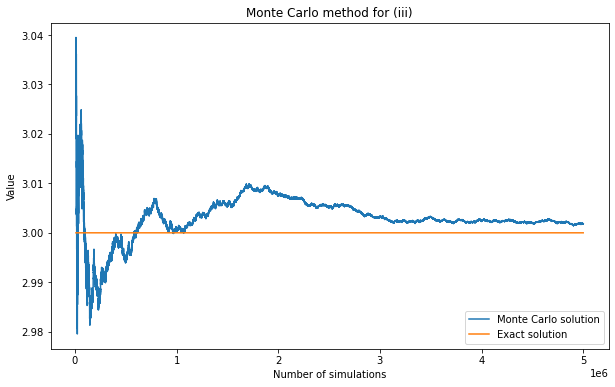

Numerical value of the integral (iii) after 5000000 simulations is 3.0018


In [195]:
N = 5000000
np.random.seed(42)

vector_iii = func_iii(np.random.uniform(eps, 1, N))
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, N + 1)[10000:],  (vector_iii.cumsum() / np.arange(1, N + 1))[10000:],
         label="Monte Carlo solution")
plt.plot(np.arange(1, N + 1)[10000:], [3] * len(np.arange(1, N + 1)[10000:]), label='Exact solution')
plt.legend(loc='lower right', frameon=True)
plt.title('Monte Carlo method for (iii)')
plt.xlabel('Number of simulations')
plt.ylabel('Value')
plt.show()
print("Numerical value of the integral (iii) after %d simulations is %.4f" % (N, vector_iii.mean()))

In the same manner as in (i), we notice that the original form of the integral is also an expectation, so the problem is equivalent to estimating the expected value of $x^4$ for a standard normal variable. As numpy has the ability to simulate normal distributions, we can use it to see if there is any difference in calculations and performance. Moreover, as $x^4$ is not just any function, but the one that gives us kurtosis in its expectation, we can try doing almost no-code numerical integration by calculating the sample kurtosis of simulated data (reasonably assuming that scipy uses consistent estimates).

In [182]:
np.random.seed(42)
print(func_iii(np.random.uniform(eps, 1, N)).mean(),
      (np.random.normal(0, 1, N) ** 4).mean(),
      kurtosis(np.random.normal(0, 1, N), fisher=False))
%timeit (func_iii(np.random.uniform(eps, 1, N)).mean())
%timeit ((np.random.normal(0, 1, N) ** 4).mean())
%timeit (kurtosis(np.random.normal(0, 1, N), fisher=False))

3.0018209723226543 3.000065973652269 3.0002707405644577
273 ms ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
273 ms ± 4.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
197 ms ± 6.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It's interesting that the performance of simulating normal samples is no worse than the performance of simulating samples from a uniform distribution. It most likely would not be the case if we implemented excel-style normal variable simulation with the inverse function of normal CDF function. Kudos to numpy and python!